# Imports

In [3]:
# imports

import os
import numpy as np
import random
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
from utils import *

# Import and split data

In [4]:
# define file directory
directory = '../data/interim/PatternNet/images'

# create a list of all possible classes
all_classes = []
for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
        all_classes.append(item)
#print(all_classes)
        
# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']
        
# inspect the number of images per class
data = []
for class_name in classes:
    class_dir = os.path.join(directory, class_name)
    image_count = len(os.listdir(class_dir))
    data.append([class_name, image_count])
image_count_df = pd.DataFrame(data, columns=['Class', 'Total Image Count'])
print("The following classes were selected for evaluation:")
display(image_count_df)

# define the train, val, and test sets
train_files, val_files, test_files = generate_splits(classes, directory)

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/PatternNet/images'

# Inspect examples

In [5]:
# Global tuning
FREQBINS = 25
SIGMA = 30

# From EDA
ROWS = 256
COLS = 256

In [4]:
def fft_image(image):

    # Read the image
    # image = plt.imread(image)

    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image

    ydim, xdim = image_gray.shape
    win = np.outer(np.hanning(ydim),np.hanning(xdim))
    win = win/np.mean(win)
    
    # Compute the 2D FFT of the grayscale image
    fft_image = np.fft.fft2(image_gray*win)

    # Shift the zero frequency component to the center
    fft_image_shifted = np.fft.fftshift(fft_image)

    # Compute the magnitude spectrum (absolute value) of the shifted FFT
    magnitude_spectrum = np.abs(fft_image_shifted)
    
    return magnitude_spectrum


In [5]:
def apply_bandpass_filter(image, low_cutoff, high_cutoff):
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image
   
    # Compute the 2D FFT of the image
    fft_image = np.fft.fft2(image_gray)
    fft_shifted = np.fft.fftshift(fft_image)
    
    # Create a mask for the bandpass filter
    rows, cols = image_gray.shape
    mask = np.zeros((rows, cols), np.uint8)
    center = (rows // 2, cols // 2)
    mask[int(center[0] - high_cutoff):int(center[0] + high_cutoff), int(center[1] - high_cutoff):int(center[1] + high_cutoff)] = 1
    mask[int(center[0] - low_cutoff):int(center[0] + low_cutoff), int(center[1] - low_cutoff):int(center[1] + low_cutoff)] = 0
    
    # Apply the mask to the frequency domain representation
    fft_shifted_filtered = fft_shifted * mask
    
    # Compute the inverse 2D FFT
    ifft_shifted_filtered = np.fft.ifftshift(fft_shifted_filtered)
    filtered_image = np.fft.ifft2(ifft_shifted_filtered)
    filtered_image = np.abs(filtered_image)
    
    return filtered_image.astype(np.uint8)


In [6]:
def create_filter(rows, cols, sigma):
    # Create Gaussian Filter: Low Pass Filter
    M,N = rows, cols
    H = np.zeros((M,N), dtype=np.float32)
    D0 = sigma
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = np.exp(-D**2/(2*D0*D0))

    return H

In [7]:
def apply_gaussian_filter(image, filt):
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image_gray = np.mean(image, axis=2)
    else:
        image_gray = image

    # Compute the 2D FFT of the image
    fft_image = np.fft.fft2(image_gray)
    fft_shifted = np.fft.fftshift(fft_image)

    # Apply the mask to the frequency domain representation
    fft_shifted_filtered = fft_shifted * filt
    
    # Compute the inverse 2D FFT
    ifft_shifted_filtered = np.fft.ifftshift(fft_shifted_filtered)
    filtered_image = np.fft.ifft2(ifft_shifted_filtered)
    filtered_image = np.abs(filtered_image)

    return filtered_image.astype(np.uint8)


In [8]:
def create_dataframe(histogram_bins):
    fixed_column_names = ['class_name', 'class_id']
    empty_df = pd.DataFrame(columns=fixed_column_names)

    # Additional column names generated using list comprehension
    bin_names = [f'Bin_{i}' for i in range(1, histogram_bins + 1)] 

    # Add the additional columns to the empty DataFrame
    for column_name in bin_names:
        empty_df[column_name] = None  # Add the column with None values

    # Display the resulting DataFrame
    return (empty_df)


In [9]:
# define a function to show a grid of spectrum images in a directory (given a file subset)
def generate_freq_spectrum(files, directory, images_per_class=3):
    # create a dictionary to store class images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []
        # append image to class list
        class_images[class_name].append(img)

    # create a grid of images
    count = 0
    pd1 = create_dataframe(histogram_bins=FREQBINS)
    pd2 = create_dataframe(histogram_bins=FREQBINS)
    filt = create_filter(ROWS, COLS, SIGMA)
    
    num_classes = len(class_images)
    #fig, axes = plt.subplots(num_classes, images_per_class + 1, figsize=(12, 3*num_classes))
    for i, (class_name, images) in enumerate(class_images.items()):
        # display class name in the first column
        #axes[i, 0].text(0.5, 0.5, class_name, fontsize=16, ha='center', va='center')
        #axes[i, 0].axis('off')

        # display random images in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            magnitude_spectrum = fft_image(images[j])
            spec = np.log(1+magnitude_spectrum).ravel()
            
            hist, bins = np.histogram(spec, bins=FREQBINS) 
            hist1_df = pd.DataFrame([hist], columns=[f'Bin_{i}' for i in range(1, len(hist) + 1)], dtype=int)
            hist1_df['class_name'] = class_name
            hist1_df['class_id'] = i

            #low_cutoff = 0
            #high_cutoff = 0
            #filtered_image = apply_bandpass_filter(images[j], low_cutoff, high_cutoff)
            filtered_image = apply_gaussian_filter(images[j], filt)

            magnitude_spectrum = fft_image(filtered_image)
            spec = np.log(1+magnitude_spectrum).ravel()
            
            hist, bins = np.histogram(spec, bins=FREQBINS) 
            hist2_df = pd.DataFrame([hist], columns=[f'Bin_{i}' for i in range(1, len(hist) + 1)], dtype=int)
            hist2_df['class_name'] = class_name
            hist2_df['class_id'] = i
            
            #print(class_name, spec.min(), spec.max(), spec.mean(), spec.std(), np.median(spec))
            #axes[i, j+1].hist(spec.ravel(), bins=FREQBINS)
            #axes[i, j+1].imshow(np.log(1 + magnitude_spectrum), cmap='gray')
            #axes[i, j+1].imshow(images[j], cmap='gray')
            #axes[i, j+1].imshow(filtered_image, cmap='gray')

            count += 1
            
            #pd1 = pd1.append(hist1_df, ignore_index=True)
            #pd2 = pd2.append(hist2_df, ignore_index=True)
            pd1 = pd.concat([pd1, hist1_df], ignore_index=True)
            pd2 = pd.concat([pd2, hist2_df], ignore_index=True)


    #plt.tight_layout()
    #plt.show()
    
    return pd1, pd2

In [10]:
# show a grid with 3 random images per class
df1, df2 = generate_freq_spectrum(train_files, directory, images_per_class=450)

In [11]:
df2

,class_name,class_id,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,...,Bin_16,Bin_17,Bin_18,Bin_19,Bin_20,Bin_21,Bin_22,Bin_23,Bin_24,Bin_25
0,parking_space,0,18,60,210,742,2278,7288,17655,20498,...,516,208,102,8,4,0,0,4,4,1
1,parking_space,0,24,84,233,830,2731,7777,17474,18902,...,1026,642,316,182,48,12,0,4,4,1
2,parking_space,0,14,58,220,788,2499,7260,17762,19614,...,766,352,186,148,102,2,0,4,4,1
3,parking_space,0,24,68,244,748,2522,7732,17606,19784,...,566,208,74,18,0,0,0,4,4,1
4,parking_space,0,14,40,282,935,3305,9804,20162,15757,...,416,172,120,38,16,6,0,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,harbor,9,28,80,252,874,2568,7272,15912,15977,...,1574,1040,634,280,146,76,6,2,6,1
4496,harbor,9,16,50,253,700,2418,7224,15860,15912,...,1696,1132,642,300,158,48,6,8,6,1
4497,harbor,9,36,120,356,1136,3372,8759,17104,14698,...,1118,856,642,354,170,98,32,2,4,5
4498,harbor,9,4,44,152,498,1980,6216,14906,18027,...,1640,1198,492,134,72,24,6,0,6,1


In [12]:
grouped_df = df2.loc[:,'class_id':'Bin_25'].groupby('class_id')
summary_df = grouped_df.agg(['median'])
print(summary_df)

          Bin_1  Bin_2  Bin_3  Bin_4   Bin_5   Bin_6    Bin_7    Bin_8  \
         median median median median  median  median   median   median   
class_id                                                                 
0          14.0   60.0  232.0  826.0  2743.5  8292.5  18675.5  18417.0   
1          14.0   63.0  241.0  891.0  3005.0  9016.5  19393.0  16306.0   
2          12.0   44.0  161.0  539.0  1688.0  4926.0  12122.0  18467.0   
3          14.0   56.0  210.0  772.0  2566.0  7839.5  18072.0  18716.5   
4          17.0   66.0  255.0  857.5  2738.5  7950.5  17918.0  20648.0   
5          14.0   52.0  196.0  688.0  2298.5  6866.5  15816.5  17662.0   
6          16.0   60.0  227.0  830.5  2765.0  8343.5  18322.5  17148.5   
7          14.0   56.0  215.0  775.0  2633.0  7990.0  17411.0  15650.0   
8          16.0   62.0  248.0  894.0  3028.0  9331.5  20430.0  17562.5   
9          14.0   53.0  196.0  670.5  2192.5  6498.5  15095.5  17423.0   

            Bin_9  Bin_10  ...  Bin_1

In [13]:
df2.loc[0:4, 'class_name': 'Bin_10']

,class_name,class_id,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,Bin_10
0,parking_space,0,18,60,210,742,2278,7288,17655,20498,5498,2198
1,parking_space,0,24,84,233,830,2731,7777,17474,18902,5350,2210
2,parking_space,0,14,58,220,788,2499,7260,17762,19614,5700,2242
3,parking_space,0,24,68,244,748,2522,7732,17606,19784,5591,2124
4,parking_space,0,14,40,282,935,3305,9804,20162,15757,3652,2500


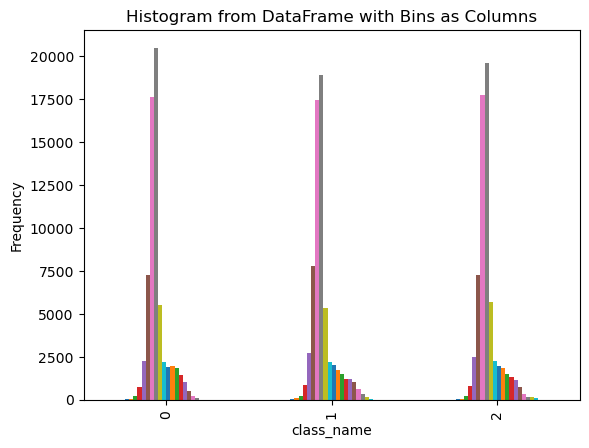

In [14]:
df2.loc[0:2, 'Bin_1': 'Bin_20'].plot(kind='bar', legend=False)
plt.xlabel(df2.columns[0])
plt.ylabel('Frequency')
plt.title('Histogram from DataFrame with Bins as Columns')
plt.show()


In [15]:
df2.loc[:,'class_id':'Bin_14']

,class_id,Bin_1,Bin_2,Bin_3,Bin_4,Bin_5,Bin_6,Bin_7,Bin_8,Bin_9,Bin_10,Bin_11,Bin_12,Bin_13,Bin_14
0,0,18,60,210,742,2278,7288,17655,20498,5498,2198,1912,1976,1872,1446
1,0,24,84,233,830,2731,7777,17474,18902,5350,2210,2006,1758,1490,1230
2,0,14,58,220,788,2499,7260,17762,19614,5700,2242,1962,1828,1520,1340
3,0,24,68,244,748,2522,7732,17606,19784,5591,2124,1830,1832,1740,1634
4,0,14,40,282,935,3305,9804,20162,15757,3652,2500,2266,1972,1778,1302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,9,28,80,252,874,2568,7272,15912,15977,4966,2728,2766,2238,2290,2046
4496,9,16,50,253,700,2418,7224,15860,15912,4710,2676,2624,2438,2342,2170
4497,9,36,120,356,1136,3372,8759,17104,14698,4070,2624,2250,2138,2316,1862
4498,9,4,44,152,498,1980,6216,14906,18027,5808,2792,2640,2624,2418,2094


In [6]:
# Use this codeblock to read from pre-trained data

csv_name = f'freq_spec_lpf_{SIGMA}_bins_{FREQBINS}.csv'
directory = '../data/processed/'
file = directory + csv_name
df2 = pd.read_csv(directory+csv_name)

In [11]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

shuffled_df = df2.sample(frac=1).reset_index(drop=True)

X = shuffled_df.loc[:, 'Bin_1': 'Bin_25']
y = shuffled_df['class_name']

# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100, max_depth=10)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# using metrics module for accuracy calculation
print("Accuracy of RF model:", metrics.accuracy_score(y_test, y_pred))

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)# Fit the classifier to the data
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy of KNN model: ", knn.score(X_test, y_test))


ACCURACY OF RF MODEL: 0.9014814814814814


0.78

In [7]:
csv_name = f'freq_spec_lpf_{SIGMA}_bins_{FREQBINS}.csv'
directory = '../data/processed/'
file = directory + csv_name
df2.to_csv(directory+csv_name, index=False)

             PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
Bin_1   0.177919  0.233452 -0.096029  0.086717 -0.173938  0.036725  0.342723   
Bin_2   0.212166  0.249822 -0.082155  0.065266 -0.129921  0.046583  0.219552   
Bin_3   0.234716  0.246820 -0.079323  0.034467 -0.087513  0.035380  0.151449   
Bin_4   0.245361  0.245300 -0.072470  0.019846 -0.051204  0.038831  0.085346   
Bin_5   0.253468  0.236119 -0.062882 -0.007646 -0.006697  0.038561  0.019397   
Bin_6   0.261694  0.214219 -0.041765 -0.035181  0.054278  0.028924 -0.084395   
Bin_7   0.269687  0.108823  0.045723 -0.057814  0.151808 -0.025528 -0.347184   
Bin_8  -0.124914 -0.359198  0.186362  0.085358 -0.039227 -0.089341 -0.092619   
Bin_9  -0.197276 -0.234391 -0.022873  0.069865 -0.206456  0.100726  0.510725   
Bin_10 -0.212949 -0.032297 -0.235443 -0.068034 -0.046500  0.363414  0.338687   
Bin_11 -0.206788  0.095871 -0.287592 -0.107588  0.103780  0.353856 -0.132173   
Bin_12 -0.214621  0.125968 -0.290465 -0.

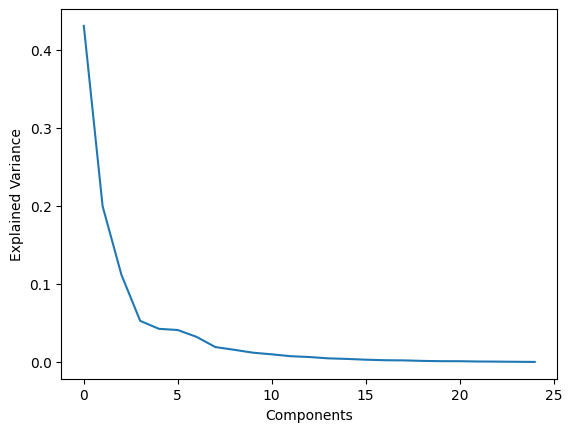

In [8]:
from sklearn.decomposition import PCA

df = df2.loc[:, 'Bin_1': 'Bin_25']

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()



In [33]:
dictbin = {}
for i in loadings.columns:
    k = loadings.sort_values(by=[i])
    bincount = 0
    for bins in k.index:
        bincount += 1
        if bincount == 10:
            break
        if bins in dictbin:
            dictbin[bins] += 1
        else:
            dictbin[bins] = 0

sorted_by_values= sorted(dictbin,key=lambda x:dictbin[x],reverse=True)
print(dictbin)


{'Bin_15': 11, 'Bin_14': 7, 'Bin_16': 7, 'Bin_13': 9, 'Bin_17': 8, 'Bin_12': 15, 'Bin_18': 10, 'Bin_10': 7, 'Bin_11': 16, 'Bin_8': 9, 'Bin_9': 10, 'Bin_23': 7, 'Bin_24': 7, 'Bin_25': 7, 'Bin_7': 11, 'Bin_1': 6, 'Bin_2': 10, 'Bin_21': 5, 'Bin_20': 11, 'Bin_3': 6, 'Bin_22': 3, 'Bin_19': 6, 'Bin_6': 4, 'Bin_4': 5, 'Bin_5': 3}
